In [9]:
import os 
import sys 
sys.path.append('..')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import torch
from torch.utils.data import DataLoader
from src.py_dataset import *
register_matplotlib_converters()

## 画出训练曲线

In [2]:
# df = pd.read_csv('../result/LSTM_result_file.csv')
# df = pd.read_csv('../result/ANN_nD.csv')
# df = pd.read_csv('../result/one_LSTM_result_file.csv')
df = pd.read_csv('../result/LSTM_1D.csv')
# df = pd.read_csv('../result/EDLSTM_nD.csv')
# df = pd.read_csv('../result/EDLSTM_1D_tf.csv')
# df = pd.read_csv('../result/STAttention.csv')

In [4]:
file_list = ['../result/STAttention.csv', '../result/EDLSTM_1D_tf.csv', 
             '../result/EDLSTM_nD.csv', '../result/LSTM_1D.csv',
             '../result/ANN_nD.csv']

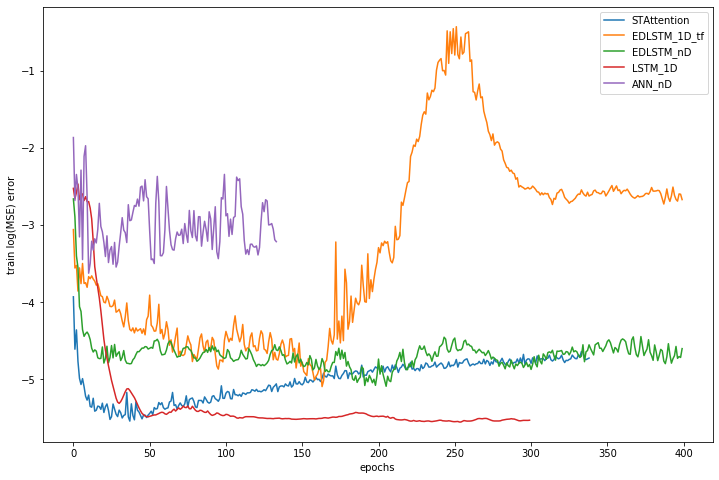

In [44]:
plt.figure(facecolor='w', figsize=(12, 8))
for file in file_list:
    df = pd.read_csv(file)
    train_curve = df['train_mse_curve'].iloc[-1]
    valid_curve = df['valid_mse_curve'].iloc[-1]
    train_curve = list(map(float, train_curve[1: -1].split(',')))
    valid_curve = list(map(float, valid_curve[1: -1].split(',')))
#     plt.plot(np.log(train_curve))
    plt.plot(np.log(valid_curve))
#     plt.legend(['train', 'valid'])
plt.legend([i[10: -4] for i in file_list])
plt.xlabel('epochs')
plt.ylabel('train log(MSE) error')
plt.savefig('../result/figures/valid_loss_model_compare.png', format='png', dpi=500)
plt.show()

In [8]:
train_curve = df['train_mse_curve'].iloc[-1]
valid_curve = df['valid_mse_curve'].iloc[-1]
train_curve = list(map(float, train_curve[1: -1].split(',')))
valid_curve = list(map(float, valid_curve[1: -1].split(',')))

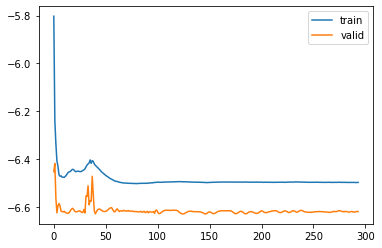

In [9]:
plt.figure(facecolor='w')
plt.plot(np.log(train_curve))
plt.plot(np.log(valid_curve))
plt.legend(['train', 'valid'])
plt.show()

## 探究模型效果

In [5]:
import sys
sys.path.append('..')
import torch
from datetime import datetime
from torch.utils.data import DataLoader
from src.py_dataset import GpuDataset
from matplotlib import pyplot as plt

In [13]:
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/ANN_nD.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/one_LSTM.pkl', map_location='cpu')
model = torch.load('../rnn_model/saved_pkl_model/LSTM_1D.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM_nD.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM_1D_tf.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/STAttention.pkl', map_location='cpu')
model.eval()
batch_size = 16
dataset_path = '../Dataset/3bs_8q_4p_dataset_washed.csv'
dataset = GpuResidualDataset('valid', dataset_path, 40, 4)
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)
data = dataset.data
df_seasonal = dataset.df_seasonal

dataset prepared !


In [14]:
model

LSTM_1D(
  (LSTM): LSTM(1, 64, num_layers=2, dropout=0.5)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (Tanh): Tanh()
)

In [23]:
# output_list = []
# for i, (input_p, input_time, label_p, decoder_time) in enumerate(dataloader):
#     print(i, end='')
# #     print(\r, i, end='')
#     outputs_p = model(input_p, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
# #     outputs_p = model(input_p, input_time)
#     for j in range(0, batch_size):
#         output_list += [outputs_p[j, -1].detach().numpy()]
# #                     outputs_p[1, -1].detach().numpy()]
#     if i > 4200/batch_size:
#         break

# # 多步预测
# output_list = []
# output_list_30min = []
# label_list = []
# for i, (input_p_q, input_time, label_p, decoder_time) in enumerate(dataloader):
#     label_list += [label_p[:,43]]
#     for j in range(0, 4):
#         outputs_p = model(input_p_q, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
#         label_p[:, 0:39] = label_p[:,1:40]
#         label_p[:, 39] = outputs_p.squeeze(2)[:,-1]
#         if j == 0:
#             output_list_30min += [outputs_p[0, -1, :].detach().numpy()]    
#         if j == 3:
#             output_list += [outputs_p[0, -1, :].detach().numpy()]
# #     if i > 1500:
# #         break

# data['out_pressure_pred'] = 0
# data['out_pressure_pred'].iloc[:len(output_list)] = output_list
# data['out_pressure_pred'] = data['out_pressure_pred'].copy().shift(40+4)

# 多步预测，加重构
output_list = []
diff_list = []
label_list = []
for i, (input_p_q, input_time, label_p, decoder_time) in enumerate(dataloader):
    print(i, end='')
    label_list += [label_p[:,43]]
    diff = np.zeros([batch_size, 1])
    for j in range(0, 4):
        outputs_p = model(input_p_q, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
        label_p[:, 0:39] = label_p[:,1:40]
        label_p[:, 39] = outputs_p.squeeze(2)[:,-1]
        diff += outputs_p[:, -1, :].detach().numpy()
    diff_list += [diff]

0123456789

KeyboardInterrupt: 

In [25]:
np.flatten(diff_list)

AttributeError: module 'numpy' has no attribute 'flatten'

In [36]:
dataset.df_resid

AttributeError: 'GpuDataset' object has no attribute 'df_resid'

In [32]:
data['diff'] = 0
data['diff'].iloc[:len(diff_list)] = diff_list
data['diff'] = data['diff'].copy().shift(40+4-1)
data['out_pressure_pred'] = data['q8'].shift(4) + data['diff']
data

G:\Anaconda\envs\pytorch_env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Unnamed: 0,datetime,timestamp,q1,p1,p2,q2,q3,p3,q4,...,p6,p7,season,weekday,hour,month,weekofyear,out_pressure,diff,out_pressure_pred
29053,58106,2019-01-01 00:30:00,1546273800,0.207455,0.00,0.00,0.290323,0.340139,0.125,0.225191,...,0.516505,0.633605,1,1,0,1,1,0.224880,NaN,NaN
29054,58108,2019-01-01 01:00:00,1546275600,0.171799,0.00,0.00,0.243280,0.278097,0.000,0.190840,...,0.645631,0.673833,1,1,1,1,1,0.167464,NaN,NaN
29055,58110,2019-01-01 01:30:00,1546277400,0.175041,0.00,0.00,0.240591,0.251286,0.000,0.171756,...,0.611650,0.711827,1,1,1,1,1,0.153110,NaN,NaN
29056,58112,2019-01-01 02:00:00,1546279200,0.178282,0.00,0.00,0.241935,0.214187,0.000,0.160305,...,0.550485,0.734177,1,1,2,1,1,0.114833,NaN,NaN
29057,58114,2019-01-01 02:30:00,1546281000,0.179903,0.00,0.25,0.241935,0.182556,0.000,0.152672,...,0.591262,0.735294,1,1,2,1,1,0.100478,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33541,67082,2019-04-04 12:30:00,1554352200,0.426256,0.25,0.25,0.299731,0.624273,0.375,0.698473,...,0.311262,0.671151,2,3,12,4,14,0.641148,0.0,0.751196
33542,67084,2019-04-04 13:00:00,1554354000,0.403566,0.50,0.50,0.240591,0.600024,0.375,0.622137,...,0.557282,0.680538,2,3,13,4,14,0.588517,0.0,0.650718
33543,67086,2019-04-04 13:30:00,1554355800,0.388979,0.25,0.50,0.247312,0.578975,0.375,0.610687,...,0.604854,0.689925,2,3,13,4,14,0.578947,0.0,0.669856
33544,67088,2019-04-04 14:00:00,1554357600,0.343598,0.25,0.50,0.239247,0.570979,0.375,0.583969,...,0.506796,0.767701,2,3,14,4,14,0.583732,0.0,0.684211


In [21]:
data

,Unnamed: 0,datetime,timestamp,q1,p1,p2,q2,q3,p3,q4,...,p6,p7,season,weekday,hour,month,weekofyear,out_pressure,diff,out_pressure_pred
29053,58106,2019-01-01 00:30:00,1546273800,0.207455,0.00,0.00,0.290323,0.340139,0.125,0.225191,...,0.516505,0.633605,1,1,0,1,1,0.224880,NaN,NaN
29054,58108,2019-01-01 01:00:00,1546275600,0.171799,0.00,0.00,0.243280,0.278097,0.000,0.190840,...,0.645631,0.673833,1,1,1,1,1,0.167464,NaN,NaN
29055,58110,2019-01-01 01:30:00,1546277400,0.175041,0.00,0.00,0.240591,0.251286,0.000,0.171756,...,0.611650,0.711827,1,1,1,1,1,0.153110,NaN,NaN
29056,58112,2019-01-01 02:00:00,1546279200,0.178282,0.00,0.00,0.241935,0.214187,0.000,0.160305,...,0.550485,0.734177,1,1,2,1,1,0.114833,NaN,NaN
29057,58114,2019-01-01 02:30:00,1546281000,0.179903,0.00,0.25,0.241935,0.182556,0.000,0.152672,...,0.591262,0.735294,1,1,2,1,1,0.100478,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33541,67082,2019-04-04 12:30:00,1554352200,0.426256,0.25,0.25,0.299731,0.624273,0.375,0.698473,...,0.311262,0.671151,2,3,12,4,14,0.641148,0.0,0.641148
33542,67084,2019-04-04 13:00:00,1554354000,0.403566,0.50,0.50,0.240591,0.600024,0.375,0.622137,...,0.557282,0.680538,2,3,13,4,14,0.588517,0.0,0.588517
33543,67086,2019-04-04 13:30:00,1554355800,0.388979,0.25,0.50,0.247312,0.578975,0.375,0.610687,...,0.604854,0.689925,2,3,13,4,14,0.578947,0.0,0.578947
33544,67088,2019-04-04 14:00:00,1554357600,0.343598,0.25,0.50,0.239247,0.570979,0.375,0.583969,...,0.506796,0.767701,2,3,14,4,14,0.583732,0.0,0.583732


In [28]:
data['out_pressure_pred'] = 0
data['out_pressure_pred'].iloc[:len(output_list)] = output_list
data['out_pressure_pred'] = data['out_pressure_pred'].copy().shift(40+4)
# data['datetime'] = data['datetime'].apply(str_to_datetime)

G:\Anaconda\envs\pytorch_env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


../result/figures/LSTM_1D.png
fig_rewrited !


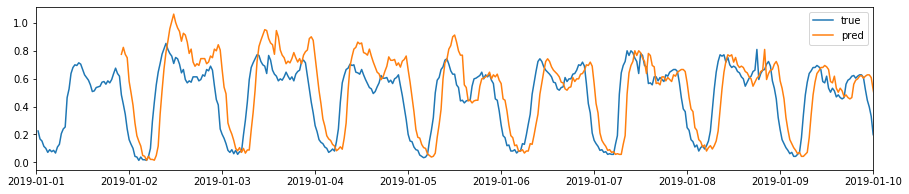

In [33]:
plt.figure(figsize=(15,3), facecolor='w')
plt.plot(data['datetime'], data['out_pressure'])
plt.plot(data['datetime'], data['out_pressure_pred'])
plt.xlim([datetime(2019,1,1), datetime(2019, 1, 10)])
fig_path = '../result/figures/' + model.model_name + '.png'
print(fig_path)
if not os.path.exists(fig_path):
    plt.savefig(fig_path, format='png',dpi=1000)
    print('fig_svaed !')
else:
    plt.savefig(fig_path, format='png',dpi=1000)
    print('fig_rewrited !')
plt.legend(['true', 'pred'])
plt.show()

In [34]:
from sklearn import metrics
import numpy as np
from sklearn import preprocessing
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['MAE'] = metrics.mean_absolute_error(y_true, y_pred)
    metrics_dict['MSE'] = metrics.mean_squared_error(y_true, y_pred)
    metrics_dict['MAPE'] = np.mean(np.true_divide(np.abs(y_true-y_pred), y_true))
    return metrics_dict
y_pred = data['out_pressure_pred'].iloc[48:].values
y_true = data['q8'].iloc[48:].values 
eval_dict = eval_metrics(y_true, y_pred)
eval_dict

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


{'MAE': 0.13795596484132738, 'MSE': 0.03930149290619443, 'MAPE': nan}

In [28]:
float(diff)

0.11498492956161499

## spatial attention

In [51]:
att_score = np.array([0.0164, 0.0113, 0.0131, 0.0449, 0.0701, 0.0171, 0.0236, 0.0078, 0.0054,
        0.0056, 0.0065, 0.0065, 0.0171, 0.0315, 0.1486, 0.0105, 0.0078, 0.0061])
columns = ['q'+str(i) for i in range(1,12)] + ['p'+str(i) for i in range(1,8)]

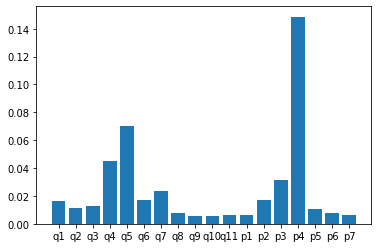

In [55]:
plt.figure(facecolor='w')
plt.bar(columns, att_score)
plt.savefig('../result/figures/spatial_attention_score.png')

## temporal attention

In [59]:
att_score = np.array([0.1488, 0.1728, 0.1884, 0.2039, 0.2198, 0.2400, 0.2644, 0.2974, 0.3336,
        0.3977, 0.3691, 0.2976, 0.2594, 0.2369, 0.2377, 0.2448, 0.2570, 0.2649,
        0.2577, 0.2458, 0.2378, 0.2258, 0.2172, 0.2142, 0.2094, 0.2200, 0.2254,
        0.2049, 0.1860, 0.1767, 0.1746, 0.1739, 0.1728, 0.1729, 0.1789, 0.1936,
        0.2109, 0.2112, 0.2061, 0.2000])
x = list(range(-40,0))

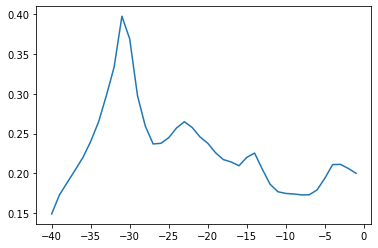

In [62]:
plt.figure(facecolor='w')
plt.plot(x, att_score)
plt.savefig('../result/figures/temporal_attention.png')